In [ ]:
import importlib.util
spec = importlib.util.find_spec("src.io")
print("Python is loading:", spec.origin)


In [1]:
import sys, os
sys.path.append(r"C:\Users\zetma\Sulabh\MS AAI USD\MS Assignment\Module2 Final Project\New Version Project")



In [2]:
import inspect, importlib.util, sys

spec = importlib.util.find_spec("src.io")
print("File path:", spec.origin)


File path: C:\Users\zetma\Sulabh\MS AAI USD\MS Assignment\Module2 Final Project\New Version Project\src\io.py


In [3]:
from src.io import load_gold_csv
print(load_gold_csv)


<function load_gold_csv at 0x000002C3BBC505E0>


In [4]:
from src.forecasting import fit_models, forecast_models, eval_metrics, plot_fcst_vs_actual

print(fit_models)
print(forecast_models)
print(eval_metrics)
print(plot_fcst_vs_actual)


<function fit_models at 0x000002C3CC1302C0>
<function forecast_models at 0x000002C3DD50B6A0>
<function eval_metrics at 0x000002C3DD5382C0>
<function plot_fcst_vs_actual at 0x000002C3DE954180>


{'MAE': 17.97537146942977, 'RMSE': np.float64(20.759181987590953)}


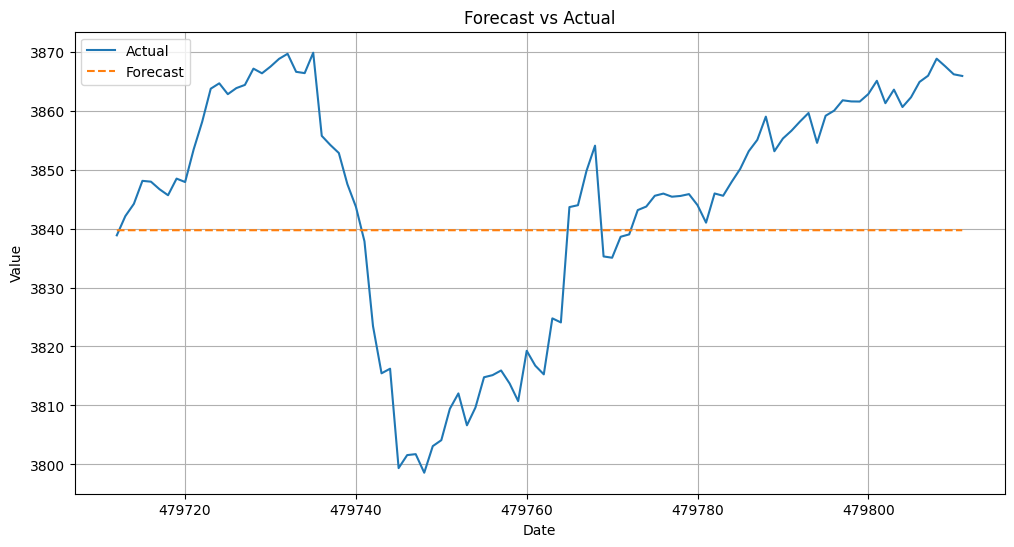

In [5]:
from src.io import load_gold_csv
from src.cleaning import basic_clean
from src.features import add_returns_features
from src.forecasting import fit_models, forecast_models, eval_metrics, plot_fcst_vs_actual
import pandas as pd
import numpy as np

# 1. Load and clean data
df = load_gold_csv("../data/raw/XAU_15m_data.csv")
df = basic_clean(df)
df = add_returns_features(df, price_col="close")

# 2. Split into train/test
train = df.iloc[:-100]   # all but last 100 points
test = df.iloc[-100:]    # last 100 points

# 3. Fit ARIMA model
model_fit = fit_models(train, target_col="close", order=(1,1,1))

# 4. Forecast
forecast = forecast_models(model_fit, steps=len(test))

# 5. Evaluate
metrics = eval_metrics(test["close"], forecast)
print(metrics)

# 6. Plot
plot_fcst_vs_actual(test["close"], forecast)


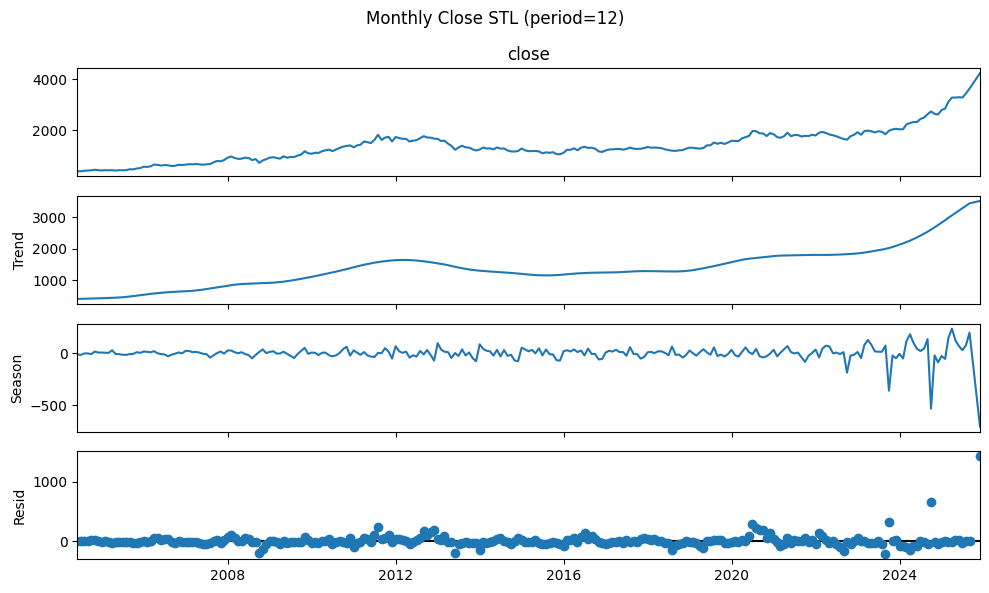

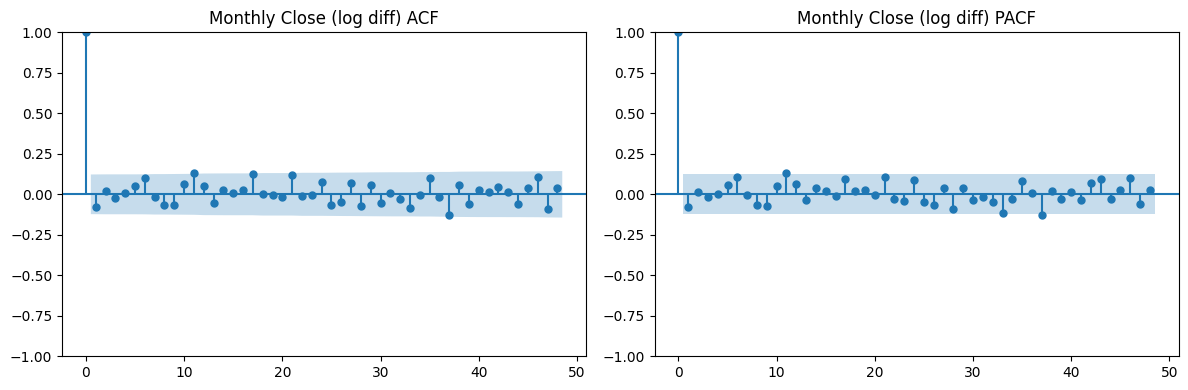

In [7]:
from src.io_monthly import load_monthly_gold_csv
from src.diagnostics import acf_pacf_plots, stl_decompose, prepare_stationary

df_m = load_monthly_gold_csv("../data/raw/XAU_1Month_data.csv")
close_m = df_m["close"]

# STL on level series (period=12 for monthly)
stl_result = stl_decompose(close_m, period=12, title="Monthly Close STL (period=12)")

# ACF/PACF on differenced log series
close_m_stat = prepare_stationary(close_m, use_log=True, diff_order=1)
acf_pacf_plots(close_m_stat, max_lag=48, title_prefix="Monthly Close (log diff)")


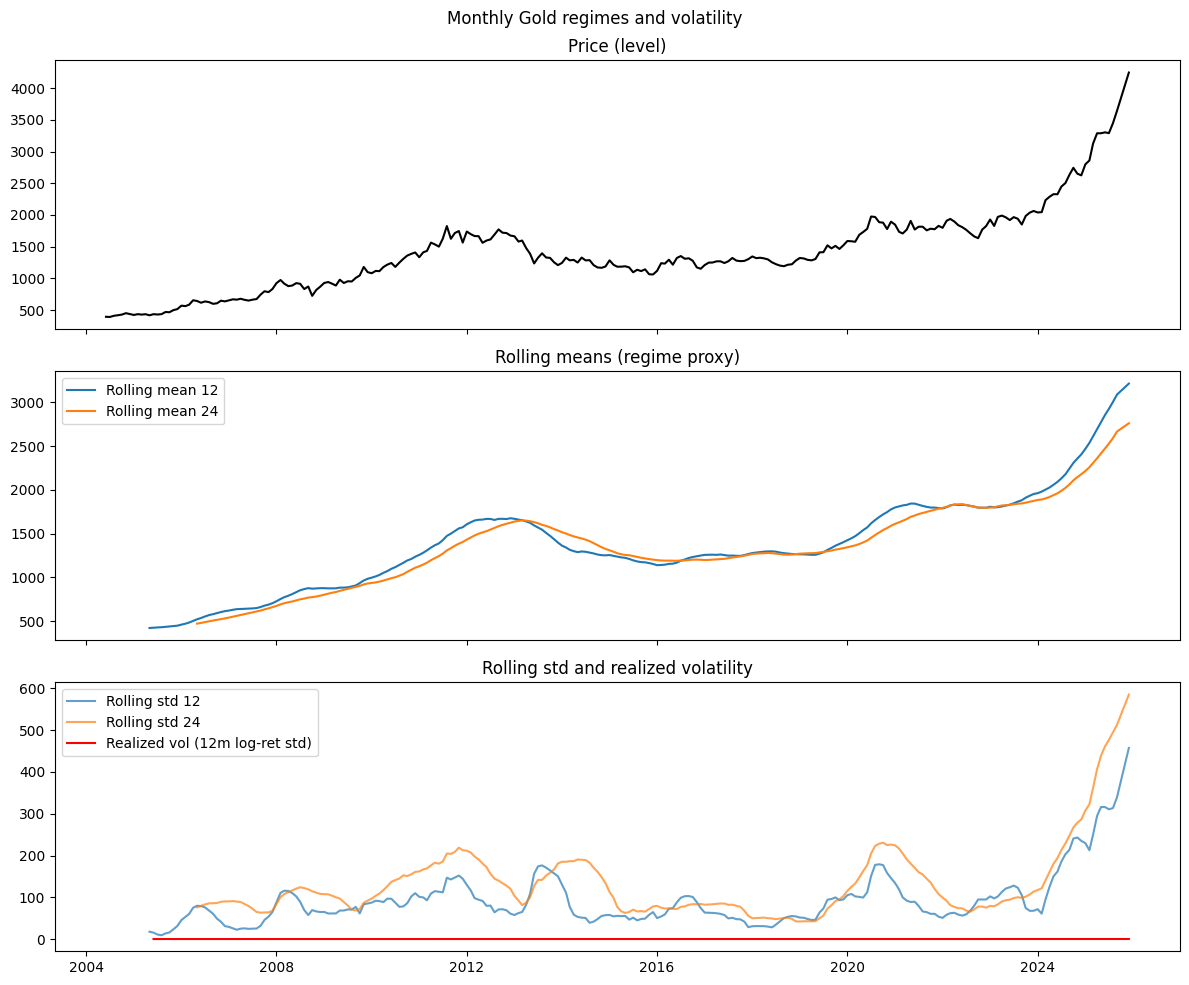

              value    zscore  regime_flag
date                                      
2025-06-01  3302.92  1.799297            1
2025-07-01  3290.68  1.598803            1
2025-08-01  3448.16  1.731537            1
2025-09-01  3642.56  1.903710            1
2025-12-01  4246.31  2.540300            1


In [8]:
from src.io_monthly import load_monthly_gold_csv
from src.regimes_vol import plot_regime_vol, zscore_regimes

df_m = load_monthly_gold_csv("../data/raw/XAU_1Month_data.csv")
close_m = df_m["close"]

plot_regime_vol(close_m, windows=(12, 24), title="Monthly Gold regimes and volatility")
reg_df = zscore_regimes(close_m, window=24, threshold=1.0)
print(reg_df.tail())


C:\Users\zetma\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zetma\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zetma\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA metrics: {'MAE': 692.0667846482748, 'RMSE': np.float64(870.8979787085452), 'MAPE': np.float64(22.32372789315603)}
Holt-Winters metrics: {'MAE': 695.812848505943, 'RMSE': np.float64(874.085610197274), 'MAPE': np.float64(22.4607906480793)}


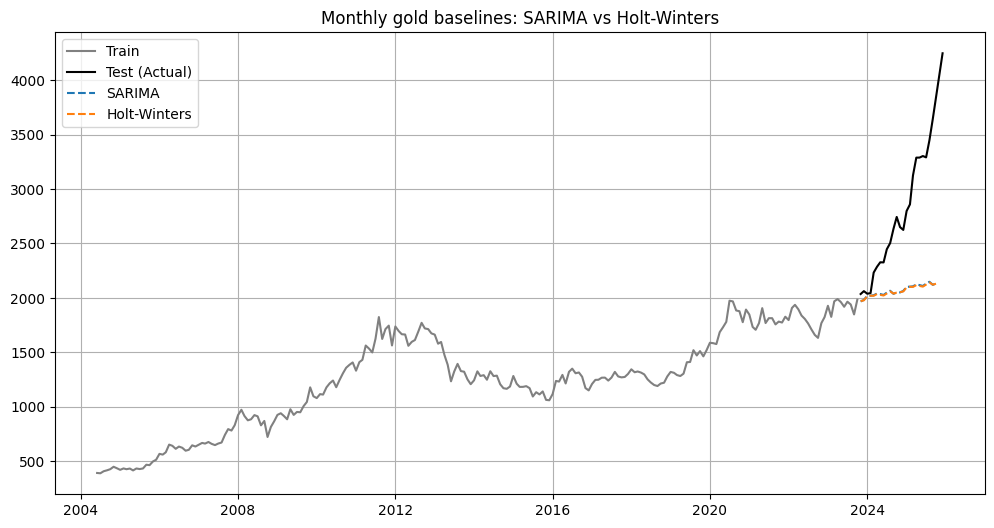

In [10]:
from src.io_monthly import load_monthly_gold_csv
from src.baselines import time_split, fit_sarima_forecast, fit_holt_winters_forecast, evaluate_forecast, plot_forecasts

df_m = load_monthly_gold_csv("../data/raw/XAU_1Month_data.csv")
close_m = df_m["close"].dropna()

# Train/test split (last 24 months as test)
train, test = time_split(close_m, test_size=24)

# Fit SARIMA (tune as needed; start simple)
sarima_res, sarima_pred = fit_sarima_forecast(train, test, order=(1,1,1), seasonal_order=(0,1,1,12))
sarima_metrics = evaluate_forecast(test, sarima_pred)

# Fit Holt-Winters (additive)
hw_res, hw_pred = fit_holt_winters_forecast(train, test, trend="add", seasonal="add", seasonal_periods=12)
hw_metrics = evaluate_forecast(test, hw_pred)

print("SARIMA metrics:", sarima_metrics)
print("Holt-Winters metrics:", hw_metrics)

# Plot comparison
plot_forecasts(train, test, preds={"SARIMA": sarima_pred, "Holt-Winters": hw_pred},
               title="Monthly gold baselines: SARIMA vs Holt-Winters")
